In [59]:
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

from typing import List
from lightkurve.correctors import DesignMatrix

In [2]:
%matplotlib notebook

In [3]:
bss_candidates: pd.DataFrame = pd.read_csv('./bss_candidates.csv')

In [4]:
bss_candidates.phot_variable_flag.value_counts()

NOT_AVAILABLE    24
VARIABLE          2
Name: phot_variable_flag, dtype: int64

In [5]:
variable_bss = bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']

In [6]:
variable_bss.g

21    15.3331
23    13.4074
Name: g, dtype: float64

In [7]:
variable_bss.TIC

21    461599358.0
23    461601525.0
Name: TIC, dtype: float64

In [8]:
yss_candidates: pd.DataFrame = pd.read_csv('./yss_candidates.csv')
variable_yss = yss_candidates[yss_candidates.phot_variable_flag=='VARIABLE']

In [9]:
variable_yss.TIC

5    461601177.0
Name: TIC, dtype: float64

In [11]:
variable_yss

,H,H_error,J,J_error,K,K_error,source_id,twomass_id,g,g_error,...,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,g-r,g-r_error,g_abs,g_abs_error,outlier
5,11.676,0.029,12.167,0.027,11.551,0.021,573941053907094144,00452260+8512381,14.3779,0.008363,...,0.121948,0.994924,0.01554,1.938335,0.054283,0.298497,0.009195,1.458724,0.054842,-1


# Lightcurve

In [12]:
from lightkurve.correctors import load_tess_cbvs, load_kepler_cbvs
import numpy as np

In [151]:
ts1 = lk.search_tesscut('TIC 461601525')

In [56]:
ts1

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,TESScut,1426,TIC 461601525,0.0
1,TESS Sector 19,2019,TESScut,1426,TIC 461601525,0.0
2,TESS Sector 20,2019,TESScut,1426,TIC 461601525,0.0
3,TESS Sector 25,2020,TESScut,1426,TIC 461601525,0.0
4,TESS Sector 26,2020,TESScut,1426,TIC 461601525,0.0
5,TESS Sector 40,2021,TESScut,475,TIC 461601525,0.0
6,TESS Sector 52,2022,TESScut,475,TIC 461601525,0.0


<IPython.core.display.Javascript object>


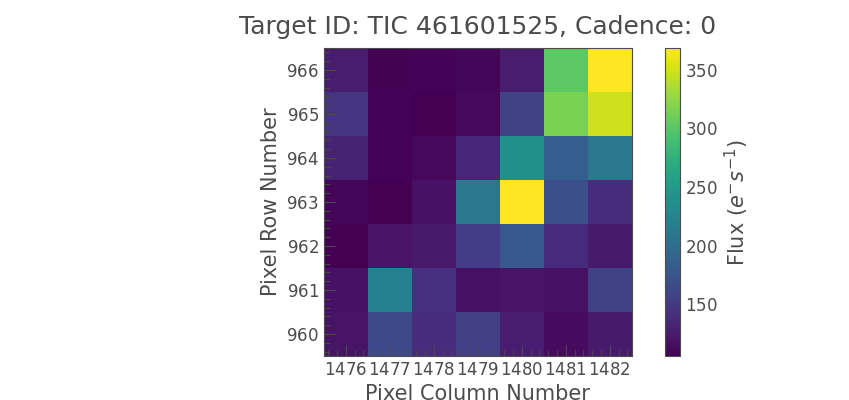

<AxesSubplot:title={'center':'Target ID: TIC 461601525, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

In [148]:
tpf = ts1[6].download(cutout_size=7)
tpf.plot()

In [228]:
aper = tpf.create_threshold_mask()

<IPython.core.display.Javascript object>


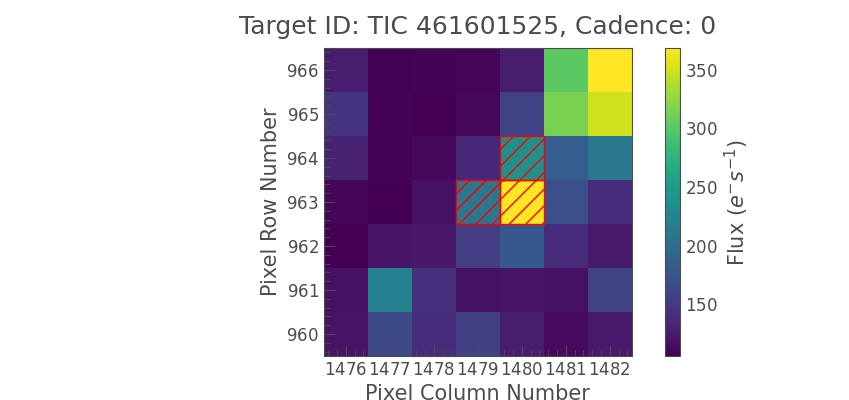

In [229]:
tpf.plot(aperture_mask=aper);

In [230]:
regressors = tpf.flux[:, ~aper]

In [231]:
regressors.shape

(3343, 46)

<IPython.core.display.Javascript object>


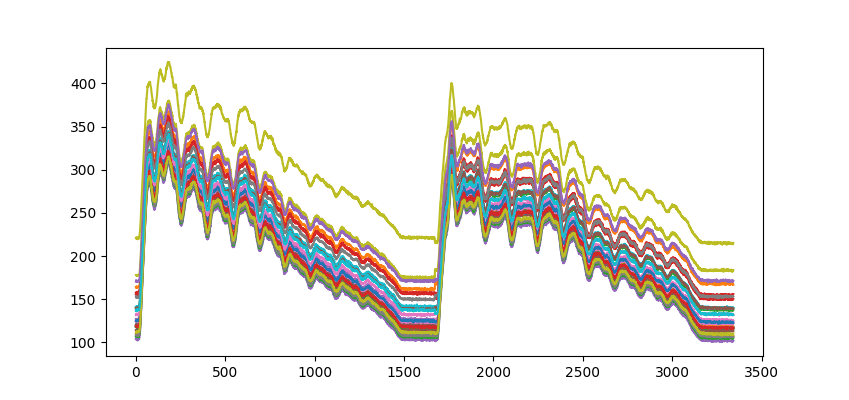

In [232]:
plt.figure();
plt.plot(regressors[:, :30]);

In [233]:

dm = DesignMatrix(regressors, name='regressors')

<IPython.core.display.Javascript object>


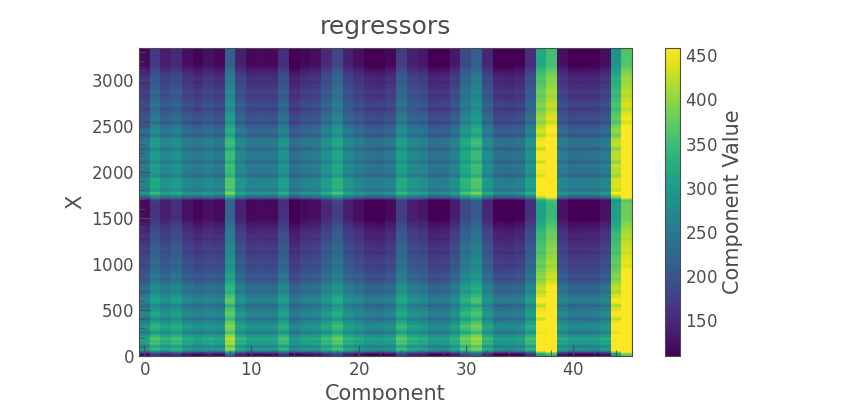

<AxesSubplot:title={'center':'regressors'}, xlabel='Component', ylabel='X'>

In [234]:
dm.plot()

<IPython.core.display.Javascript object>


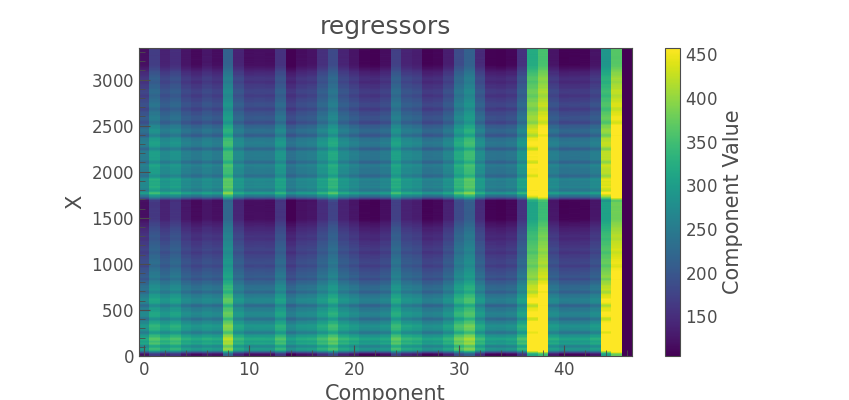

<AxesSubplot:title={'center':'regressors'}, xlabel='Component', ylabel='X'>

In [235]:
dm = dm.append_constant();
dm.plot()

<IPython.core.display.Javascript object>


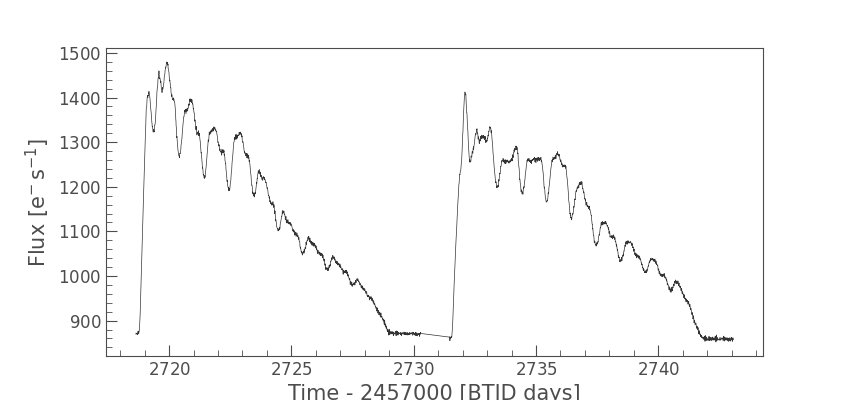

In [236]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot();

In [237]:
corrector = lk.RegressionCorrector(uncorrected_lc)
corrected_lc = corrector.correct(dm)

<IPython.core.display.Javascript object>


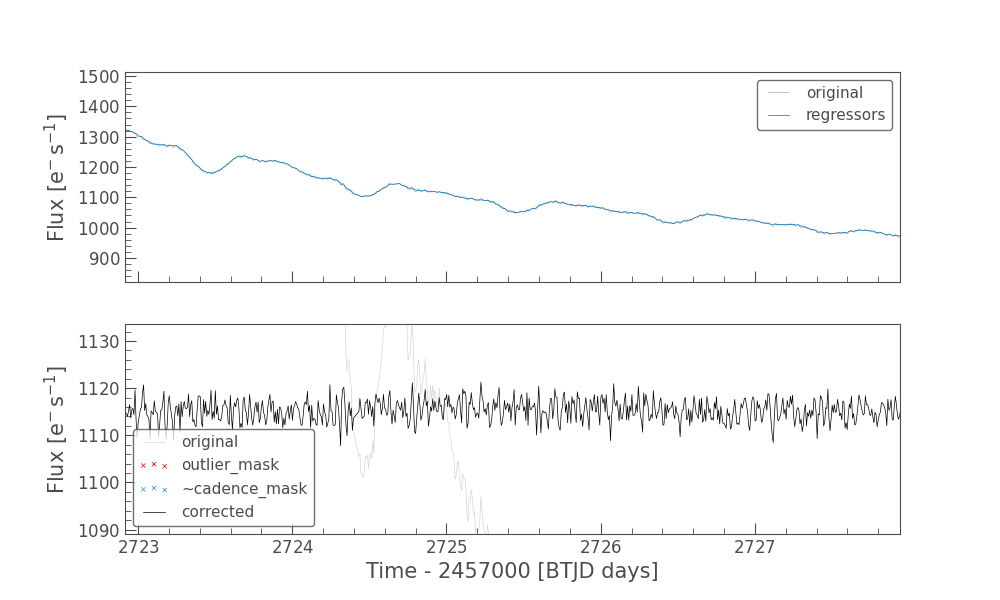

In [238]:
corrector.diagnose();

<IPython.core.display.Javascript object>


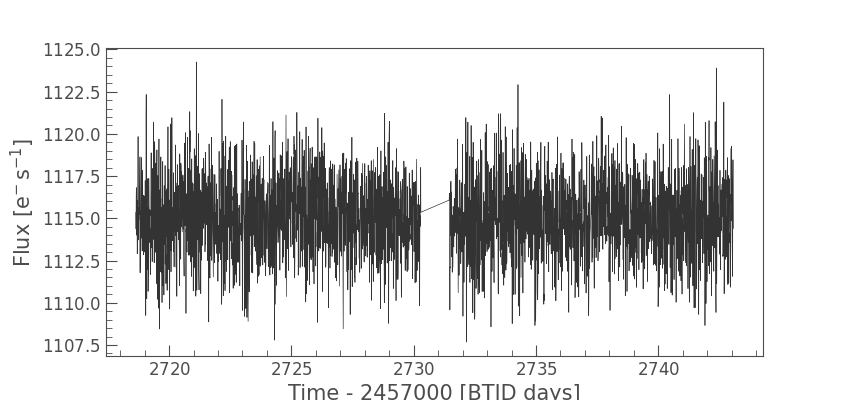

In [239]:
corrected_lc.plot();

<IPython.core.display.Javascript object>


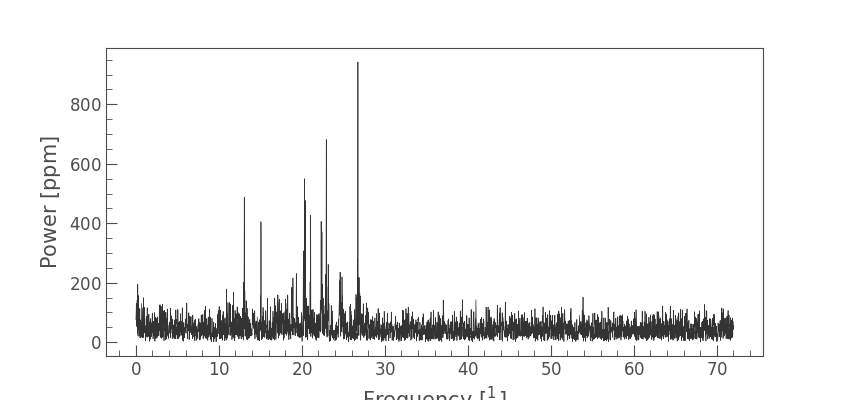

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

In [240]:
pg = corrected_lc.normalize(unit='ppm').to_periodogram()
pg.plot()

In [241]:
pg.period_at_max_power

<Quantity 0.03736658 d>

/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/lightcurve.py:1937: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


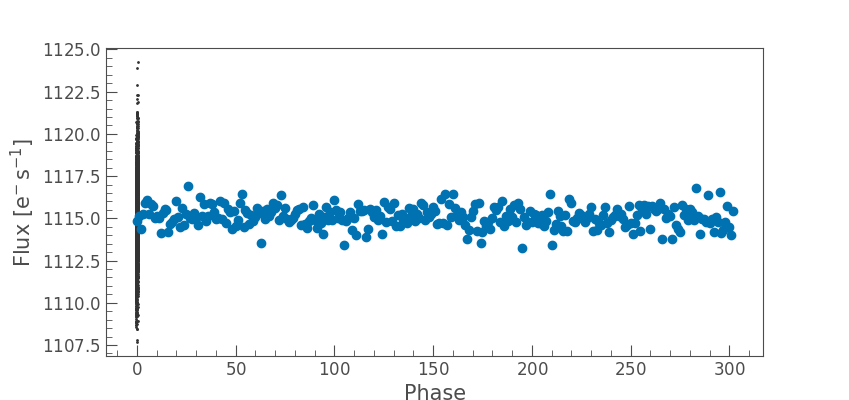

In [271]:
fc = corrected_lc.fold(pg.period_at_max_power, normalize_phase=True);
fc.scatter();

In [272]:
corrected_lc_pd = fc.to_pandas()

In [273]:
corrected_lc_pd.head()

,flux,flux_err,time_original,centroid_col,centroid_row,cadenceno,quality
time,,,,,,,
-0.499898,1113.287729,1.460176,2022-05-30 16:01:28.841333763,1479.761884,963.275927,1654,0
-0.499235,1116.353958,1.619726,2022-06-01 05:41:26.848359508,1479.741083,963.278637,1714,0
-0.498848,1114.165078,1.773286,2022-06-02 00:31:26.027489722,1479.727531,963.287503,1827,0
-0.498426,1116.247103,1.718247,2022-06-02 19:21:25.321505574,1479.732073,963.284199,1940,0
-0.497982,1114.586409,1.745043,2022-06-03 14:11:24.687880603,1479.729540,963.284672,2053,0


In [298]:
len(corrected_lc_pd.flux.values[:3330])

3330

In [305]:
means = np.mean(np.split(corrected_lc_pd.flux.values[:3330], 111), axis=0)
means.shape

(30,)

In [306]:
len(means)

30

<IPython.core.display.Javascript object>


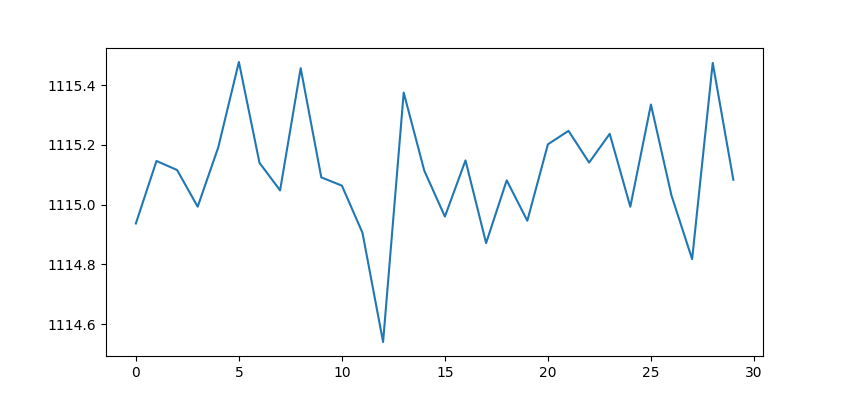

In [308]:
plt.figure();
plt.plot(np.arange(30), means)

In [263]:
corrected_lc

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,pix,pix,,
Time,float64,float64,float64,float64,int64,int32
2718.640099657997,1115.3447062054734,1.4601759940374421,1479.7582919204233,963.2731320825654,0,0
2718.6470439411455,1114.3739027696492,1.4620327031800098,1479.75840211837,963.2731997437954,1,0
2718.653988224295,1116.3128469911233,1.4614644451743146,1479.7582276777025,963.2735079431654,2,0
2718.6609325076774,1116.8190422372409,1.4614590616512138,1479.7578736430062,963.2719009213071,3,0
2718.6678767912936,1114.0073765929915,1.4603181229819235,1479.75673621264,963.2720869192574,4,0
2718.674821075141,1114.3166894558449,1.460973239400331,1479.7581646725425,963.2756169041278,5,0
...,...,...,...,...,...,...
2743.0356508771147,1111.5630975432423,1.4478397028751344,1479.7585178217232,963.2626761463915,3337,0


In [18]:
lc_result = lk.search_lightcurve('TIC 461601177', mission='TESS')

TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]


<IPython.core.display.Javascript object>


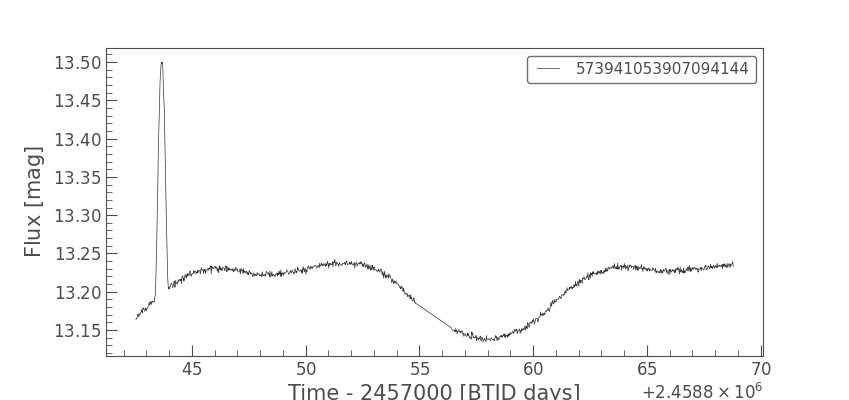

In [22]:
lc_result[4].download().plot();

In [82]:
def download_lc(tic: int, cutout_size: int = 10) -> List[lk.LightCurve]:
    ts = lk.search_tesscut(f'TIC {int(tic)}')
    print(f'Downloaded {len(ts)} tesscuts.')
    
    _, ax = plt.subplots(ncols=3, nrows=len(ts))
    
    light_curves: List[lk.lightcurve] = []
    
    for i, cut in enumerate(ts):
        try:
            tpfs = cut.download(cutout_size=cutout_size)

            aper = tpfs.create_threshold_mask()
            regressors = tpfs.flux[:, ~aper]
            dm = DesignMatrix(regressors, name='regressors')
            uncorrected_lc = tpfs.to_lightcurve(aperture_mask=aper)
            uncorrected_lc.plot(ax=ax[i, 1]);

            corrector = lk.RegressionCorrector(uncorrected_lc)
            corrected_lc = corrector.correct(dm)
            corrected_lc.plot(ax=ax[i, 2])

            tpfs.plot(ax[i, 0], aperture_mask=aper)
            ax[i, 0].set_title('')
            light_curves.append(corrected_lc)
        except:
            ax[i, 0].set_visible(False);
            ax[i, 1].set_visible(False);
            ax[i, 2].set_visible(False);
            continue
    
    return light_curves 

Downloaded 7 tesscuts.


<IPython.core.display.Javascript object>


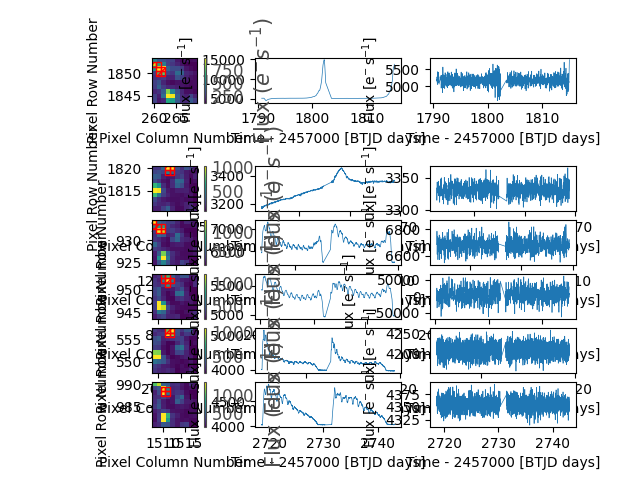

/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (25) compared to the number of columns (94), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  warnings.warn(
/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (39) compared to the number of columns (96), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  warnings.warn(
/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (27) compared to the number of columns (94), which suggests that th

[<TessLightCurve length=1103 LABEL="" SECTOR=18>
        time               flux             flux_err      ... cadenceno quality
                       electron / s       electron / s    ...                  
        Time             float64            float64       ...   int64    int32 
 ------------------ ------------------ ------------------ ... --------- -------
  1790.679047041966  5194.419096410756 2.2658028368378313 ...         0       0
 1790.6998807175037  5150.199870305335 2.2646105369564626 ...         1       0
 1790.7207143921087  5275.347539574445 2.2656762479050365 ...         2       0
 1790.7415480656668  5157.942046709596  2.266481855749436 ...         3       0
 1790.7623817384106  5114.346611500585 2.2652218163950133 ...         4       0
 1790.7832154102216  5092.030140112493  2.265639311646608 ...         5       0
                ...                ...                ... ...       ...     ...
  1814.908449730428   5146.48905279544 3.3293595151145494 ...      1097

In [83]:
download_lc(461601177)